# KKBOX’s customer churn prediction

This notebook hosts the implementation code for the KKBOX customer churn prediction project. The project objective is to build a model that can accurately predict if a customer will churn from the service.

This is a dataset of customer demographic, transaction and usage information for 194192 KKBOX customers. KKBOX is Asia’s largest subscription-based music streaming service, other companies similar to KKBOX are Spotify and Apple Music. The project objective was to build a model that can accurately predict if a customer will churn from the service. The dataset contains 25 features of demographic, transactional and usage data from the KKBOX app. A customer is said to have churned if they do not have a new valid service subscription within 30 days after their current subscription expires.s.

### Import python modules

In [0]:
import itertools
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import RobustScaler

from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from IPython.display import Image

## Load data as pandas dataframe

In [3]:


data = pd.read_csv('chrun.csv') # change path as needed!!!!

#drop 80% of entries for easy processing
features = [c for c in data.columns if c not in ['is_churn','msno']]
data_df, dropped_records, labels_df, dropped_features= train_test_split(data[features], data['is_churn'], test_size = 0.8, stratify=data['is_churn'])
data = pd.concat([data_df, labels_df], axis=1)
data.to_csv(index=True)

data_df['is_churn'] = labels_df

title: trainfinal.csv, id: 1rpIzRPYqX0AlY8Kfpj_V2-AtpF_6TbFJ
downloading to /root/ColabNotebook/data/trainfinal.csv


## Exploratory Data Analysis


In [5]:
data_df.head()

,trans_count,days_listened,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,...,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,discount,is_discount,is_churn
406329,1.0,23.0,15.0,0.0,0.0,3.0,20130204.0,36.0,30.0,180.0,...,178.0,21.0,15.0,30.0,387.0,568.0,108375.016,0.0,0,0
570971,1.0,30.0,14.0,26.0,1.0,3.0,20140220.0,40.0,30.0,149.0,...,138.0,40.0,40.0,34.0,2095.0,1575.0,586978.000,0.0,0,0
388311,1.0,9.0,18.0,19.0,2.0,3.0,20120908.0,38.0,30.0,149.0,...,45.0,9.0,5.0,5.0,207.0,231.0,50523.640,0.0,0,0
11802,0.0,4.0,1.0,0.0,0.0,9.0,20160818.0,0.0,0.0,0.0,...,21.0,30.0,12.0,13.0,120.0,59.0,36118.332,0.0,0,1
265411,1.0,23.0,1.0,0.0,2.0,7.0,20131128.0,41.0,30.0,99.0,...,98.0,49.0,23.0,9.0,238.0,180.0,67226.070,0.0,0,0


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194192 entries, 406329 to 23377
Data columns (total 25 columns):
trans_count               194192 non-null float64
days_listened             194192 non-null float64
city                      194192 non-null float64
bd                        194192 non-null float64
gender                    194192 non-null float64
registered_via            194192 non-null float64
registration_init_time    194192 non-null float64
payment_method_id         194192 non-null float64
payment_plan_days         194192 non-null float64
plan_list_price           194192 non-null float64
actual_amount_paid        194192 non-null float64
is_auto_renew             194192 non-null float64
transaction_date          194192 non-null float64
membership_expire_date    194192 non-null float64
is_cancel                 194192 non-null float64
num_25                    194192 non-null float64
num_50                    194192 non-null float64
num_75                    194192 no

In [98]:
data_df.describe()

,trans_count,days_listened,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,...,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,discount,is_discount,is_churn
count,194192.000000,194192.000000,194192.000000,194192.000000,194192.000000,194192.000000,1.941920e+05,194192.000000,194192.000000,194192.000000,...,194192.000000,194192.000000,194192.000000,194192.000000,194192.000000,194192.000000,1.941920e+05,194192.000000,194192.000000,194192.000000
mean,1.165228,13.949931,5.263502,12.032221,0.589901,6.116786,1.785844e+07,37.393837,32.560111,139.331759,...,84.150861,20.408596,12.880222,14.579082,415.761586,397.679786,1.085289e+05,0.177824,0.001684,0.089942
std,1.301702,11.328938,6.353322,21.647291,0.787878,2.844446,6.372949e+06,8.357695,33.057925,139.206120,...,152.065890,35.521423,20.769168,34.251003,700.145188,563.147264,1.720069e+05,4.924684,0.041001,0.286099
min,0.000000,0.000000,0.000000,-3152.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-149.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,2.010112e+07,37.000000,30.000000,99.000000,...,1.000000,0.000000,0.000000,0.000000,5.000000,10.000000,1.875064e+03,0.000000,0.000000,0.000000
50%,1.000000,14.000000,1.000000,0.000000,0.000000,7.000000,2.013112e+07,41.000000,30.000000,149.000000,...,32.000000,8.000000,5.000000,6.000000,182.000000,203.000000,5.018899e+04,0.000000,0.000000,0.000000
75%,1.000000,25.000000,11.000000,26.000000,1.000000,7.000000,2.015121e+07,41.000000,30.000000,149.000000,...,103.000000,26.000000,17.000000,18.000000,527.000000,552.000000,1.409049e+05,0.000000,0.000000,0.000000
max,148.000000,31.000000,22.000000,2016.000000,2.000000,13.000000,2.017033e+07,41.000000,450.000000,2000.000000,...,8557.000000,1960.000000,653.000000,3588.000000,27291.000000,9874.000000,6.615513e+06,180.000000,1.000000,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


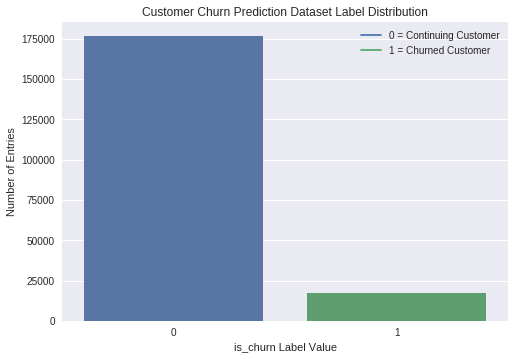

In [99]:
sns.countplot(data_df['is_churn'])
pyplot.plot(0, label ="0 = Continuing Customer")
pyplot.plot(1, label ="1 = Churned Customer")
pyplot.xlabel("is_churn Label Value")
pyplot.ylabel("Number of Entries")
pyplot.title("Customer Churn Prediction Dataset Label Distribution")
pyplot.legend()
pyplot.savefig('churn_label_skew.png')
pyplot.show()

## Training, Testing, Validation Set Split

50% training, 50% testing

In [0]:

train_X, test_X, train_y, test_y = train_test_split(data_df[features], data_df['is_churn'], test_size = 0.5, stratify=data_df['is_churn'])

## Preproccessing (Normalization)

In [0]:
preproccess = RobustScaler()
preproccess.fit(train_X)
train_X = preproccess.transform(train_X)
test_X = preproccess.transform(test_X)

## Decision Tree

In [0]:
max_depth = 15
tree_auc_train, tree_auc_test = np.zeros(max_depth), np.zeros(max_depth)
training_time, prediction_time = np.zeros(max_depth), np.zeros(max_depth)
for i in range(1,max_depth):
    clf_decision_tree = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy',random_state=1)
    t0=time.clock()
    clf_decision_tree = clf_decision_tree.fit(train_X, train_y)
    training_time[i] = round(time.clock()-t0, 3)
    tree_auc_train[i] = roc_auc_score(train_y, clf_decision_tree.predict_proba(train_X)[:,1])
    t1=time.clock()
    tree_auc_test[i] = roc_auc_score(test_y, clf_decision_tree.predict_proba(test_X)[:,1])
    prediction_time[i] = round(time.clock()-t1, 3)


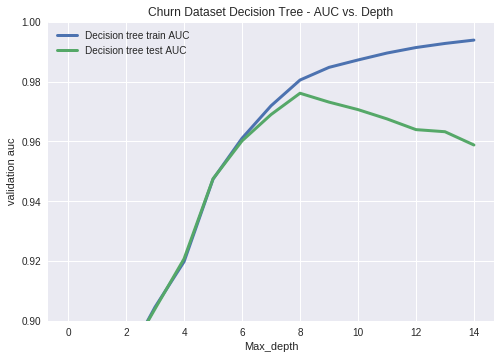

<Figure size 1152x576 with 0 Axes>

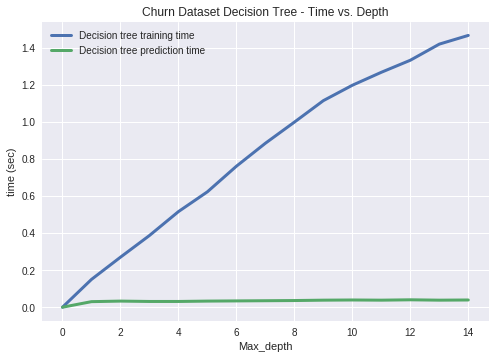

<Figure size 1152x576 with 0 Axes>

In [103]:
from matplotlib import pyplot
pyplot.plot(tree_auc_train, linewidth=3, label = "Decision tree train AUC")
pyplot.plot(tree_auc_test, linewidth=3, label = "Decision tree test AUC")
pyplot.legend()
pyplot.ylim(0.9, 1.0)
pyplot.title("Churn Dataset Decision Tree - AUC vs. Depth")
pyplot.xlabel("Max_depth")
pyplot.ylabel("validation auc")
pyplot.figure(figsize=(16,8))
pyplot.savefig('churn_treedepth_fig2')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "Decision tree training time")
pyplot.plot(prediction_time, linewidth=3, label = "Decision tree prediction time")
pyplot.legend()
pyplot.xlabel("Max_depth")
pyplot.ylabel("time (sec)")
pyplot.title("Churn Dataset Decision Tree - Time vs. Depth")
pyplot.figure(figsize=(16,8))
pyplot.savefig('churn_treedepth_time_fig2')
pyplot.show()

In [104]:
print("Best tree depth training: " + str(np.argmax(tree_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(tree_auc_train, axis=0)))
print("Best tree depth testing: " + str(np.argmax(tree_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(tree_auc_test, axis=0)))

Best tree depth training: 14
Highest AUC score training: 0.9938880621646486
Best tree depth testing: 8
Highest AUC score testing: 0.9761115333511157


### Decision tree pruning


In [105]:
from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

# plot_tree(clf, features)
# tree.export_graphviz(clf,out_file='tree.dot',class_names=['No','Yes'],feature_names=features, 
#                      filled=True, rounded=True, special_characters=True, proportion=True)
# os.system("dot -Tpng tree.dot -o tree.png")
# os.system("tree.png")
# # Note : Uncoverted Quotes (Yes) and Converted quotes (No)
# Image(filename='tree.png')


clf_decision_tree = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy',random_state=1)
clf_decision_tree = clf_decision_tree.fit(train_X, train_y)
prune_duplicate_leaves(clf_decision_tree)
    
tree_auc_train_pruned = roc_auc_score(train_y, clf_decision_tree.predict_proba(train_X)[:,1])
tree_auc_test_pruned = roc_auc_score(test_y, clf_decision_tree.predict_proba(test_X)[:,1])

print("pruned decision tree training: " + str(tree_auc_train_pruned))
print("pruned decision tree testing: " + str(tree_auc_test_pruned))

# plot_tree(clf, features)
# tree.export_graphviz(clf,out_file='tree_pruned.dot',class_names=['No','Yes'],feature_names=features, 
#                          filled=True, rounded=True, special_characters=True, proportion=True)
# os.system("dot -Tpng tree_pruned.dot -o tree_pruned.png")
# os.system("tree_pruned.png")
# # Note : Uncoverted Quotes (Yes) and Converted quotes (No)
# Image(filename='tree_pruned.png')


Pruned 13
Pruned 22
Pruned 48
Pruned 70
Pruned 69
Pruned 118
Pruned 116
Pruned 115
Pruned 146
Pruned 267
Pruned 277
Pruned 283
Pruned 281
Pruned 313
Pruned 316
Pruned 312
Pruned 377
Pruned 410
Pruned 442
Pruned 519
Pruned 566
Pruned 565
Pruned 624
Pruned 634
Pruned 637
Pruned 633
Pruned 641
Pruned 719
Pruned 717
Pruned 723
Pruned 751
Pruned 759
Pruned 758
Pruned 764
Pruned 767
Pruned 763
Pruned 757
Pruned 773
Pruned 776
Pruned 772
Pruned 780
Pruned 783
Pruned 779
Pruned 771
Pruned 788
Pruned 796
Pruned 807
Pruned 812
Pruned 815
Pruned 811
Pruned 819
Pruned 822
Pruned 818
Pruned 810
Pruned 844
Pruned 893
Pruned 904
Pruned 916
Pruned 922
Pruned 921
pruned decision tree training: 0.9913507416127685
pruned decision tree testing: 0.9563825280439413


OK


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


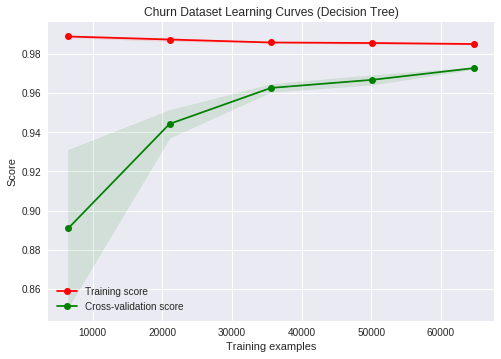

In [124]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
#   train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt
  
print("OK")


X, y = train_X, train_y

title = "Churn Dataset Learning Curves (Decision Tree)"
estimator = tree.DecisionTreeClassifier(max_depth=9, criterion='entropy',random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()

## Boosting
 

In [0]:
max_depth = 15
adaboost_auc_train, adaboost_auc_test = np.zeros(max_depth), np.zeros(max_depth)
training_time, prediction_time = np.zeros(max_depth), np.zeros(max_depth)
for i in range(1,max_depth):
    clf_adaboost = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=i,criterion='entropy'), n_estimators=10, random_state=1)
    t0 = time.clock()
    clf_adaboost = clf_adaboost.fit(train_X, train_y)
    training_time[i] = round(time.clock()-t0, 3)
    adaboost_auc_train[i] = roc_auc_score(train_y, clf_adaboost.predict_proba(train_X)[:,1])
    t1 = time.clock()
    adaboost_auc_test[i] = roc_auc_score(test_y, clf_adaboost.predict_proba(test_X)[:,1])
    prediction_time[i] = round(time.clock()-t1, 3)
    


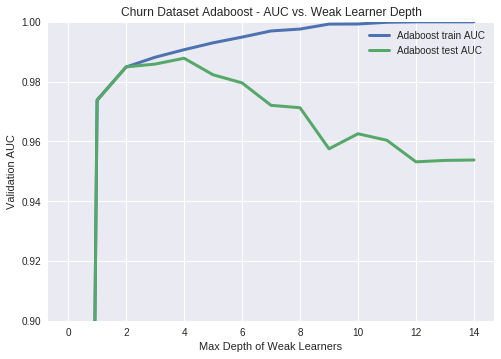

<Figure size 1152x576 with 0 Axes>

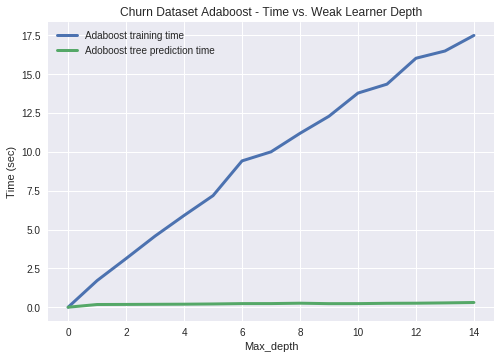

<Figure size 1152x576 with 0 Axes>

Best weak learner tree depth training: 14
Highest AUC score training: 0.9999983406206909
Best weak learner tree depth testing: 4
Highest AUC score testing: 0.9878170198327993


In [108]:
pyplot.plot(adaboost_auc_train, linewidth=3, label = "Adaboost train AUC")
pyplot.plot(adaboost_auc_test, linewidth=3, label = "Adaboost test AUC")
pyplot.legend()
pyplot.ylim(0.9, 1.0)
pyplot.xlabel("Max Depth of Weak Learners")
pyplot.ylabel("Validation AUC")
plt.title("Churn Dataset Adaboost - AUC vs. Weak Learner Depth")
pyplot.figure(figsize=(16,8))
pyplot.savefig('churn_boosting_fig4')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "Adaboost training time")
pyplot.plot(prediction_time, linewidth=3, label = "Adoboost tree prediction time")
pyplot.title("Churn Dataset Adaboost - Time vs. Weak Learner Depth")
pyplot.legend()
pyplot.xlabel("Max_depth")
pyplot.ylabel("Time (sec)")
pyplot.figure(figsize=(16,8))
pyplot.savefig('churn_boosting_time_fig2')
pyplot.show()

print("Best weak learner tree depth training: " + str(np.argmax(adaboost_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(adaboost_auc_train, axis=0)))
print("Best weak learner tree depth testing: " + str(np.argmax(adaboost_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(adaboost_auc_test, axis=0)))

OK


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


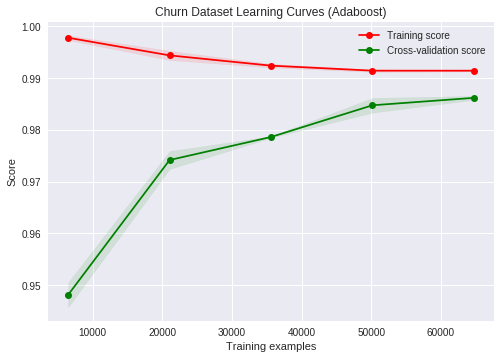

In [125]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
  
print("OK")


title = "Churn Dataset Learning Curves (Adaboost)"
estimator = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=4,criterion='entropy', random_state=1), n_estimators=10,random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()

## Neural Networks


In [0]:
learning_rate = [0.1, 1, 2, 3]
training_time, prediction_time = [],[]
nn_auc_train, nn_auc_test = [],[]
for rate in learning_rate:
    clf_nn = MLPClassifier(learning_rate_init=rate, random_state=1)
    t0 = time.clock()
    clf_nn = clf_nn.fit(train_X, train_y)
    training_time.append(round(time.clock()-t0, 3))
    nn_auc_train.append(roc_auc_score(train_y, clf_nn.predict_proba(train_X)[:,1]))
    t1 = time.clock()
    nn_auc_test.append(roc_auc_score(test_y, clf_nn.predict_proba(test_X)[:,1]))
    prediction_time.append(round(time.clock()-t1, 3))



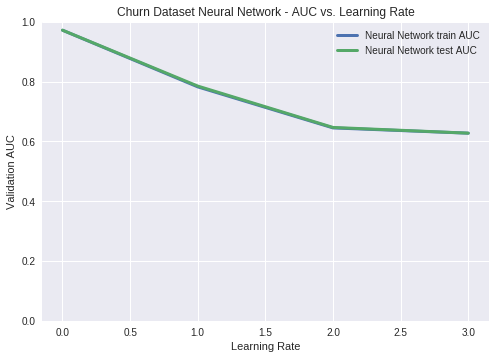

<Figure size 1152x576 with 0 Axes>

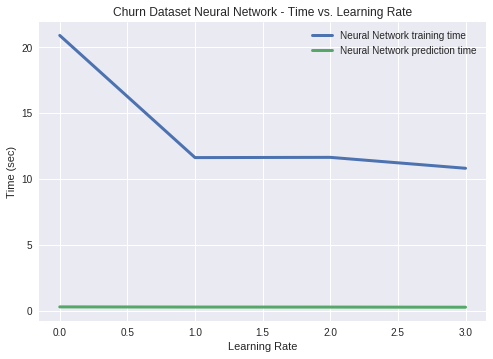

<Figure size 1152x576 with 0 Axes>

Best earning rate training: 0
Highest AUC score training: 0.9719331022132207
Best learning rate testing: 0
Highest AUC score testing: 0.9720987842070565


In [111]:
pyplot.plot(nn_auc_train, linewidth=3, label = "Neural Network train AUC")
pyplot.plot(nn_auc_test, linewidth=3, label = "Neural Network test AUC")
pyplot.legend()
pyplot.ylim(0.0, 1.0)
pyplot.xlabel("Learning Rate")
pyplot.ylabel("Validation AUC")
plt.title("Churn Dataset Neural Network - AUC vs. Learning Rate")
pyplot.figure(figsize=(16,8))
pyplot.savefig('churn_neural_network_fig')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "Neural Network training time")
pyplot.plot(prediction_time, linewidth=3, label = "Neural Network prediction time")
pyplot.legend()
pyplot.xlabel("Learning Rate")
pyplot.ylabel("Time (sec)")
pyplot.title("Churn Dataset Neural Network - Time vs. Learning Rate")
pyplot.figure(figsize=(16,8))
pyplot.savefig('churn_nn_time_fig')
pyplot.show()

print("Best earning rate training: " + str(np.argmax(nn_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(nn_auc_train, axis=0)))
print("Best learning rate testing: " + str(np.argmax(nn_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(nn_auc_test, axis=0)))

In [2]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.05, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, exploit_incremental_learning=True, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
  
print("OK")


title = "Churn Dataset Learning Curves (Neural Network)"
estimator = MLPClassifier(learning_rate_init=0.1, random_state=1)
cv = StratifiedKFold(n_splits=3,random_state=1, shuffle=False)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()

NameError: ignored

## k-Nearest Neighbors


In [0]:
max_k = 5
knn_auc_train, knn_auc_test = np.zeros(max_k), np.zeros(max_k)
training_time, prediction_time = np.zeros(max_k), np.zeros(max_k)
for i in range(1,max_k):
    clf_knn = KNeighborsClassifier(n_neighbors=i, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, p=2, weights='uniform')
    t0 = time.clock()
    clf_knn = clf_knn.fit(train_X, train_y)
    training_time[i] = round(time.clock()-t0, 3)
    pred_train = clf_knn.predict_proba(train_X)[:,1]
    t1 = time.clock()
    pred_test = clf_knn.predict_proba(test_X)[:,1]
    prediction_time[i] = round(time.clock()-t1, 3)
    knn_auc_train[i] = roc_auc_score(train_y, pred_train)
    knn_auc_test[i] = roc_auc_score(test_y, pred_test)




    
    

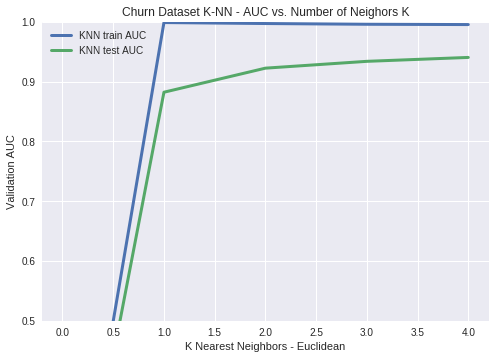

<Figure size 1152x576 with 0 Axes>

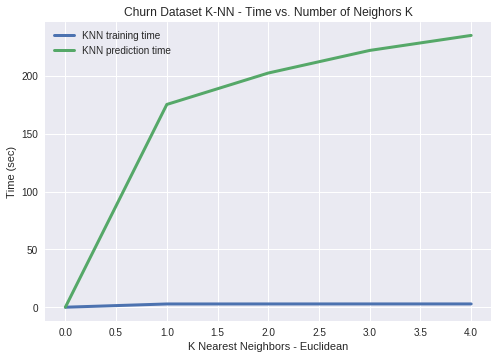

<Figure size 864x864 with 0 Axes>

Best number of neighbors training: 1
Highest AUC score training: 0.998787016403074
Best number of neighbors testing: 4
Highest AUC score testing: 0.940453050386833


In [118]:
pyplot.plot(knn_auc_train, linewidth=3, label = "KNN train AUC")
pyplot.plot(knn_auc_test, linewidth=3, label = "KNN test AUC")
pyplot.legend()
pyplot.ylim(0.5, 1.0)
pyplot.xlabel("K Nearest Neighbors - Euclidean")
pyplot.ylabel("Validation AUC")
pyplot.title("Churn Dataset K-NN - AUC vs. Number of Neighors K")
pyplot.figure(figsize=(16,8))
pyplot.savefig('churn_knn_fig6')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "KNN training time")
pyplot.plot(prediction_time, linewidth=3, label = "KNN prediction time")
pyplot.legend()
pyplot.xlabel("K Nearest Neighbors - Euclidean")
pyplot.ylabel("Time (sec)")
pyplot.title("Churn Dataset K-NN - Time vs. Number of Neighors K")
pyplot.figure(figsize=(12,12))
pyplot.savefig('churn_Knn_time_fig')
pyplot.show()

print("Best number of neighbors training: " + str(np.argmax(knn_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(knn_auc_train, axis=0)))
print("Best number of neighbors testing: " + str(np.argmax(knn_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(knn_auc_test, axis=0)))

OK


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


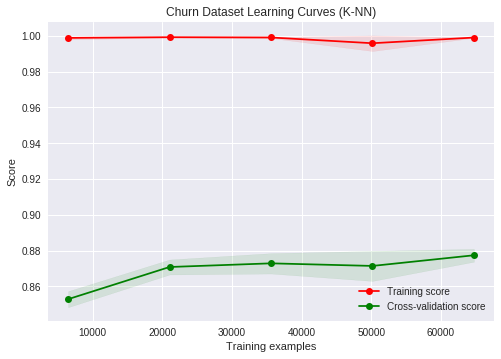

In [126]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
  
print("OK")


title = "Churn Dataset Learning Curves (K-NN)"
estimator = KNeighborsClassifier(n_neighbors=1, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, p=2, weights='uniform')
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)
plt.show()

## Support Vector Machines (SVM)

In [0]:
clf_svm_linear = SVC(kernel='linear',probability=True, random_state=1)
t0 = time.clock()
clf_svm_linear.fit(train_X, train_y)
training_time_linear = round(time.clock()-t0, 3)
pred_train_linear = clf_svm_linear.predict_proba(train_X)[:,1]
t1 = time.clock()
pred_test_linear = clf_svm_linear.predict_proba(test_X)[:,1]
prediction_time_linear = round(time.clock()-t1, 3)
svm_auc_train_linear = roc_auc_score(train_y, pred_train_linear)
svm_auc_test_linear = roc_auc_score(test_y, pred_test_linear)

clf_svm_rbf = SVC(kernel='poly',probability=True, random_state=1)
t0 = time.clock()
clf_svm_rbf.fit(train_X, train_y)
training_time_rbf = round(time.clock() - t0, 3)
pred_train_rbf = clf_svm_rbf.predict_proba(train_X)[:,1]
t1= time.clock()
pred_test_rbf = clf_svm_rbf.predict_proba(test_X)[:,1]
prediction_time_rbf = round(time.clock() - t1, 3)
svm_auc_train_rbf = roc_auc_score(train_y, pred_train_rbf)
svm_auc_test_rbf = roc_auc_score(test_y, pred_test_rbf)

print("Linear kernel training AUC: " + str(svm_auc_train_linear))
print("Linear kernel testing AUC: " + str(svm_auc_test_linear))
print("poly kernel training AUC: " + str(svm_auc_train_rbf))
print("poly kernel testing AUC: " + str(svm_auc_test_rbf))

print("Linear kernel training time: " + str(training_time_linear))
print("Linear kernel prediction tim: " + str(prediction_time_linear))
print("poly kernel training time: " + str(training_time_rbf))
print("poly kernel prediction tim: " + str(prediction_time_rbf))
                             


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt
  
print("OK")

title = "Churn Dataset Learning Curves (SVM)"
estimator = SVC(kernel='poly',probability=True, random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()
